This is the notebook for the presentation that I will be giving at the SLC python meetup tomorrow. This slide and other slides like these containing the rough planned text of the talk are "skip" slides and should (hopefully) get removed when I compile the notebook into a slides format. (Bet you didn't know nbconvert could do that!).

To make a notebook into a slide show you will also need to annotate the cells of the notebook to say whether they represent a new slide, a continuation of the previous slide (slide type indicated by a "-"), a sub-slide (optional material for a slide which can be navigated with up/down or skipped by going left right), a fragment (which is on the previous slide but appears when you next hit right), or is to be skipped all together. This information can be added by changing the cell toolbar type to slideshow ( View->Cell Toolbar->slideshow)

you can then launch the slideshow using an nbconvert command like the following,

```
jupyter nbconvert slideshow.ipynb --to slides --post serve
```

Anyway the style of this post will be slightly different than normal and you will just have to imagine me waving my hands around frantically and waiting for dramatic ... pauses. 

<!-- TEASER_END -->

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":15,
        "image.aspect":"auto",
    }
)

# Audio-Yo!


## Salt Lake City Python Meetup

## Oct, 2, 2019 



Thanks for coming to listen to me ramble on about audio data. I really love playing around with audio data in python. Auido data is somehow more exotic than other sorts of data like images and text. When I look at an image or some piece of prose I can sort of feel like I really "understand" what is there. I could sketch the picture or rewrite the text no problem. But sound is somehow more etherial I can't really "summarize" a sound, and to this day I still don't really feel like I fully understand what makes some chain of air pressure intensities translate into some humanly understandable sound.

I think working with sound data in python is just as much fun as working with image or text data and the capabilities available are less well known. I get a sort of kick out of working with music data that I just don't get when working with images and text. Some good music files and a jupyter notebook with a python environment with some decent sound libraries installed is like an incredibly fun toy, like an audio-yo if you will (ba dum psh).

#  Lofty Goal

Tackling all the different sorts of things you can do with audio data in python is a little to broad for us to be able to hit in 40 minutes. So we need some sort of organizing principle to guide our explorations. A good way to organize our story and give us direction is to then pick a goal and strive towards it.

So when Dylan asked me yesterday whether I could give a talk for the python meetup I tried to think of some worthy goal which we could strive towards.

Now, if you know me, then you will know that I'm never over ambituous... so as a nice easily achievable goal I picked the follwing,

## Write python code that creates a random sound.

Now, you might be thinking that doesn't really seem all that hard to do... I mean I thought this was a 40 minute talk. Won't we be done making a random sound in like 30 seconds? Well lets find out!

# A Random Sound Approaches!

time to code: 1 minute 36 seconds.

In [2]:
import numpy as np
import IPython.display 

sound_rate = 22500 #sound sampling rate in Hz
sound_data = np.random.normal(size=(sound_rate,))

IPython.display.Audio(sound_data, rate=sound_rate)

Apparently takes more like a minute and an half. The fact that this is so incredibly easy to do I think is something that is nothing short of incredible. It is a testament to the incredible diversity and power of the python ecosystem that I'm willing to bet that most of you have the ability to do this in your current python environment even though most of you probably don't regularly even work with audio data. To be fair this particular piece of magic is at least equally a testament to the power and flexibility of modern browsers, but I digress.

So what does this "random sound" sound like? (plays sound)

well that is kind of a let down, it just sounds like static. Lets get a new randomly sampled sound, this one is a dud.

In [3]:
sound_data2 = np.random.normal(size=(sound_rate,))
IPython.display.Audio(sound_data2, rate=sound_rate)

Well that sounds exactly like the first sound! So much so that I don't think I could tell the difference between them even if I tried. And in fact no matter how many times you draw samples from a normal distribution like this you are going to get something which sounds just the same every time. I don't think code which gives you essentially the same sound every time can really be considered "random"


At this point I think it is only appropriate to modify the wording of our goal a little bit to clarify what we want.

# What does it mean to be a "random" sound anyway?

## A Clarified Goal

## Write code that generates "random" sounds such that,

* The samples we draw cover the full range of variety of humanly perceptible sounds
* The distribution of samples is roughly perceptually uniform, (we aren't much more likely to get static than a pure tone or a tune, etc)

Put this way I think our rather glib goal of picking a "random" sound is starting to sound like it might be just a little out of scope for this talk. 

I don't really have a good answer for how to do this just a collection of thoughts. 
But I think that this is a fascinating little puzzle, it is one that I have come back to over and over again. 

# A Conceptual Sound Space 

* Start with any sound you like, (silence?) and put that sound at the origin.
* any sounds which are just perceptibly different from that sound are at radius 1.
* any sounds which are just perceptibly different each other are at a distance 1 from each other.
* build the space up till you cover the full space of possible sounds.

Something close to this sort of just perceptible differences exists in the case of color space. Where after heavy analysis of the human perception of color we have developed not one but several different ways of both fully covering the space of human color perception and of rigorously determining the perceptual "distance" between colors.

The human sense of sound is so much more complicated than that of color that probably there is no rigorous analogue of color space for sounds. Even so lets make an attempt at thinking about what such a space would be like in principle.

https://drive.google.com/drive/folders/1yBoH9eBnZ6zI682xenk9gVtlKUwb6NSc

# Human Hearing

* Frequency Range approx 20 Hz - 20,000 Hz
* Just Noticeable Frequency Difference ~ 1/20th an octave
* Volume Range approx 1 to 120 Db
* Safe Sustained Noise Level 70 Db.
* Just Noticeable Volume Difference ~ 1 Db
* Time Resolution ~ 0.1 Seconds (with maintained frequency resolution)
* Echoic Memory 3-4 seconds

Each pure tone at a particular frequency and volume is just perceptibly different from one a 20'th of an octave off from it (by regular people without the gift of perfect pitch) which divides frequency space up into roughly ${\rm log}_2(20000/20)*20 \approx 200$ steps. While overall loudness is actually a little coarser with roughly 70 divisions going from the threshold of hearing up to safe persistent levels of volume. Actually the human ear is significantly more sensitive to certain frequencies than others and so these numbers should be frequency dependent but for simplicity sake lets assume roughly 70 possible distinguishable volume levels for each frequency. 

This gives us a rough estimate for the number of possible different just perceptible sounds at 70^200

In [4]:
import scipy.interpolate
np.random.seed(20)

In [5]:
def random_atomic_sound(
    npts,
    n_freq_basis = 200,
    freq_min = 20,
    freq_max = 10000, #sampling rate of 22500 for this post -> nyquist limited
    min_log_volume = -10 #really soft
):
    log_spaced_freqs = np.exp(np.linspace(np.log(freq_min), np.log(freq_max), n_freq_basis))
    log_volumes = np.random.uniform(min_log_volume, 1, size=(n_freq_basis,) )

    linear_freqs = np.fft.rfftfreq(npts, d=1.0/sound_rate)

    interpolated_log_mags = scipy.interpolate.interp1d(
        log_spaced_freqs, 
        log_volumes,
        fill_value = -10,
        bounds_error=False,
    )(linear_freqs)

    rfft_mags = np.exp(interpolated_log_mags)
    rfft_phases = np.random.uniform(-np.pi, np.pi, size=(len(rfft_mags)))

    sound = np.fft.irfft(rfft_mags*np.exp(1j*rfft_phases))
    return locals()

Text(0,0.5,'Relative Amplitude')

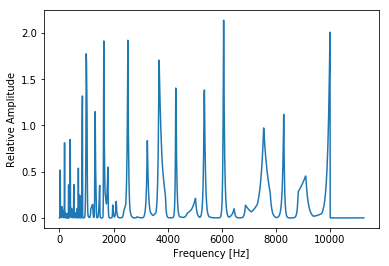

In [7]:
rsound = random_atomic_sound(npts=int(0.1*sound_rate))
plt.plot(rsound["linear_freqs"], rsound["rfft_mags"])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Relative Amplitude")

In [8]:
IPython.display.Audio(rsound["sound"], rate=sound_rate)

In [11]:
rsound = random_atomic_sound(npts=int(2.0*sound_rate))
IPython.display.Audio(rsound["sound"], rate=sound_rate)

In [12]:
IPython.display.Audio(
    np.hstack([random_atomic_sound(npts=int(0.5*sound_rate))["sound"] for i in range(20)]), 
    rate=sound_rate
)


# An Easier goal?

## Sample from the space of possible music clips.


<a href="eigen-techno.html">using PCA + stft + phase stabilization to generate eigen-techno</a>
